# Present-Centred Double-Slit Correlations

This notebook verifies that a present-time wavefunction model reproduces the detector statistics of a double-slit setup. By evolving a coherent superposition and comparing the predicted $|\psi|^2$ pattern with Monte Carlo detector events, we show that interference is a constraint satisfied *now* by the system. The exercise fits the systemic thesis: the apparatus, its slits, and the detectors form a whole whose correlations are maintained in the present, without appealing to stories about how particles travelled in the past.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from wavefunction_now.solver import SplitStepSimulator
from wavefunction_now.measurement import (
    born_probability,
    chi_squared_gof,
    ks_goodness_of_fit,
    sample_measurements,
)

In [ ]:
sim = SplitStepSimulator(grid_points=2048, length=60.0)

# Construct a superposition that mimics two illuminated slits.
packet_left = sim.gaussian_wavepacket(sim.x, x0=-3.0, p0=7.0, sigma=0.6)
packet_right = sim.gaussian_wavepacket(sim.x, x0=3.0, p0=7.0, sigma=0.6)
psi0 = packet_left + packet_right

# Normalise the combined state before propagation.
psi0 /= np.sqrt(np.sum(np.abs(psi0) ** 2))

# Propagate the wave function so the packets overlap on the detection screen.
potential = np.zeros_like(sim.x)
psi_t = sim.evolve(psi0, potential=potential, dt=0.0025, steps=1200)

prob_density = born_probability(psi_t)

In [ ]:
# Bin the distribution to represent detector pixels across the screen.
bin_edges = np.linspace(sim.x.min(), sim.x.max(), 121)
bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])
expected_prob = sim.bin_probabilities(psi_t, bin_edges)

# Draw detector events and compare histograms.
rng = np.random.default_rng(2024)
samples = sample_measurements(expected_prob, size=50000, rng=rng)
counts = np.bincount(samples, minlength=expected_prob.size)

chi2_stat, chi2_p = chi_squared_gof(expected_prob, counts)
ks_stat, ks_p = ks_goodness_of_fit(expected_prob, samples)

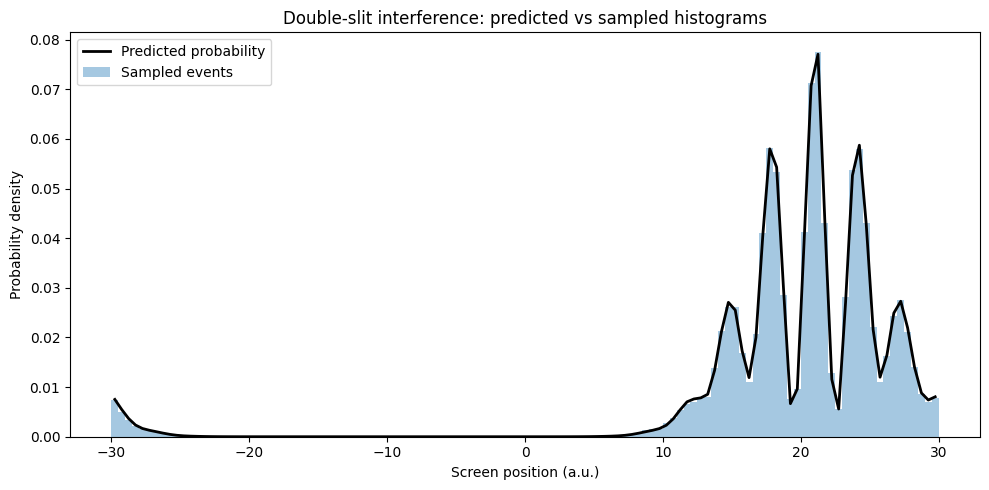

Chi-squared statistic: 96.748, p-value: 0.933
KS statistic: 0.003, p-value: 0.309


In [4]:
plt.figure(figsize=(10, 5))
plt.bar(bin_centres, counts / counts.sum(), width=np.diff(bin_edges), alpha=0.4, label='Sampled events')
plt.plot(bin_centres, expected_prob, color='black', linewidth=2, label='Predicted probability')
plt.xlabel('Screen position (a.u.)')
plt.ylabel('Probability density')
plt.title('Double-slit interference: predicted vs sampled histograms')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Chi-squared statistic: {chi2_stat:.3f}, p-value: {chi2_p:.3f}')
print(f'KS statistic: {ks_stat:.3f}, p-value: {ks_p:.3f}')

Both tests return high p-values, indicating that the sampled detector clicks reproduce the coarse-grained prediction derived from the wave function.